# Vizualize entity statistics and sample annotated molecular dynamics texts

### 🎯 Objectives
- Retrieve a dataframe summarizing, for each annotated Markdown text, the proportion of entities per class (MOLECULE, FORCEFIELD, TIME_SIMULATION, SOFTWARE, TEMPERATURE)
- Get an overview of the entities present across all annotations.
- Extract a small set of “interesting” annotations (containing at least one entity from each class) for manual review with a more visual entity display.



-------------------------------
## Package version

In [1]:
%load_ext watermark
%watermark
%watermark --packages numpy,pandas,matplotlib,seaborn

Last updated: 2025-11-14T12:27:23.560568+01:00

Python implementation: CPython
Python version       : 3.13.7
IPython version      : 8.13.2

Compiler    : GCC 14.3.0
OS          : Linux
Release     : 6.14.0-32-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

numpy     : 2.3.4
pandas    : 2.3.3
matplotlib: 3.10.7
seaborn   : 0.13.2



----------------

In [21]:
# Import libraries
import os
import math
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from spacy import displacy

In [18]:
# Constants
TSV_PATH = "../annotations/all_annotations_entities_count.tsv"
TRACKER_PATH = "../annotations/annotation_tracker.csv"

------------------------------

In [4]:
def load_tsv(path: str) -> pd.DataFrame:
    """
    Load a TSV file into a pandas DataFrame.

    Parameters
    ----------
    path : str
        Path to the TSV file.

    Returns
    -------
    pd.DataFrame
        Loaded TSV as a pandas DataFrame.
    """
    df = pd.read_csv(path, sep="\t")
    return df

df = load_tsv(TSV_PATH)
df

,filename,NB_TEMP,NB_SOFT,NB_STIME,NB_MOL,NB_FFM
0,figshare_14511885.json,0,3,1,17,0
1,figshare_5642866.json,0,0,2,10,0
2,figshare_8292209.json,0,0,0,7,0
3,zenodo_3248612.json,3,1,1,14,2
4,zenodo_6980700.json,0,0,0,2,0
...,...,...,...,...,...,...
375,figshare_1586671.json,0,0,0,3,0
376,figshare_12661589.json,2,0,0,17,0
377,figshare_21285264.json,0,0,0,8,0
378,figshare_7924394.json,0,0,1,8,0


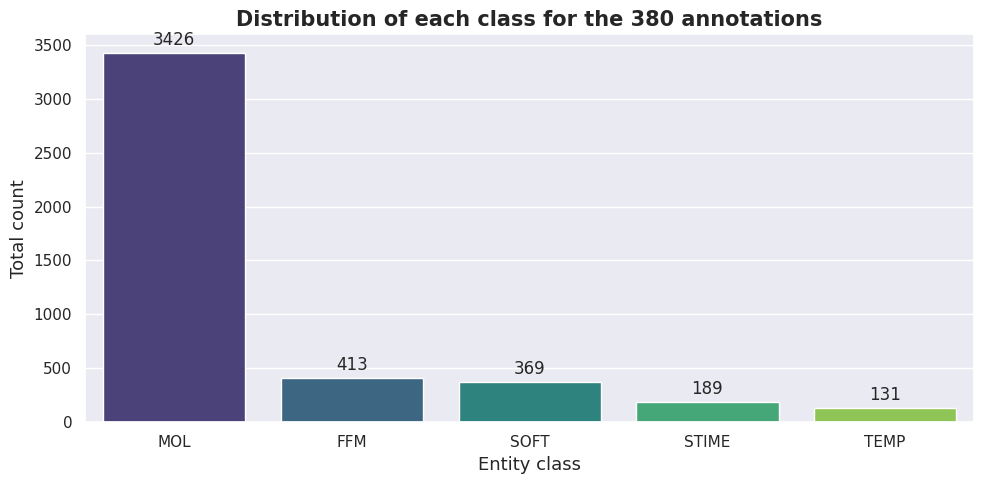

In [5]:
def plot_class_distribution(df: pd.DataFrame) -> None:
    """
    Plot a bar chart showing the total number of entities per class across all files.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing entity counts per file.
    """
    sns.set_theme()
    
    total_entities = len(df)
    cols = [col for col in df.columns if col.startswith("NB_")]
    summary = df[cols].sum().sort_values(ascending=False)
    plot_df = pd.DataFrame({
        "Class": [col.replace("NB_", "") for col in summary.index],
        "Count": summary.values
    })

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=plot_df, x="Class", y="Count", palette="viridis", hue="Class")
    # Add value labels on each bar
    for container in ax.containers:
        ax.bar_label(container, fmt="%.0f", padding=3)
    plt.title(
        f"Distribution of each class for the {total_entities} annotations",
        fontsize=15, fontweight="bold"
    )
    plt.xlabel("Entity class", fontsize=13)
    plt.ylabel("Total count", fontsize=13)
    plt.tight_layout()
    plt.show()

plot_class_distribution(df)


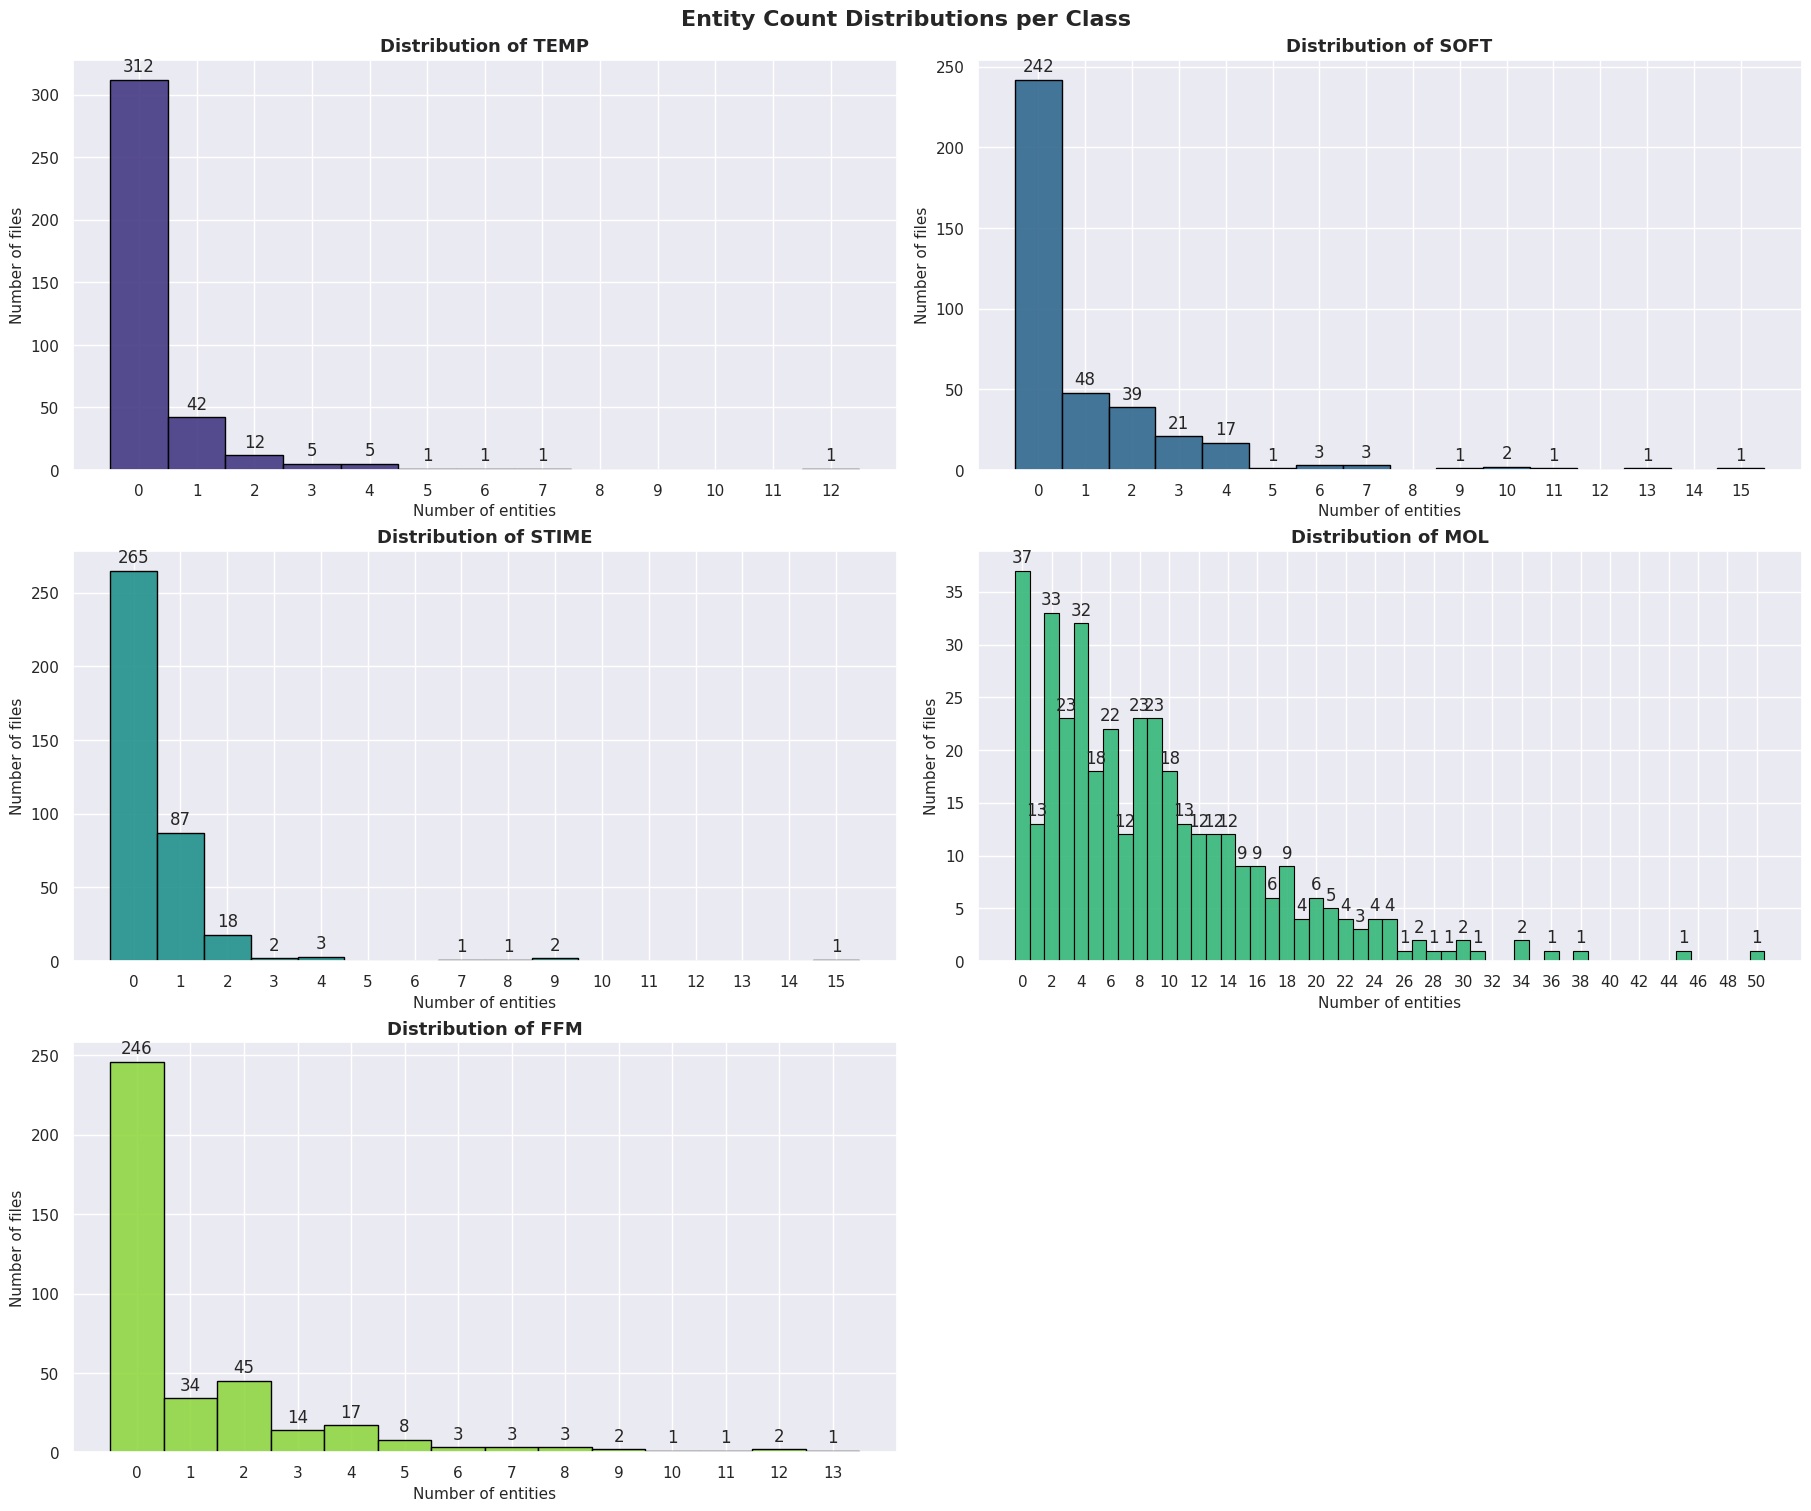

In [6]:
def plot_histograms(df: pd.DataFrame) -> None:
    """
    Plot styled histograms of entity counts for each class in a grid layout (2 per row),
    with value labels and adaptive axis ticks.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing entity counts per file.
    """
    sns.set_theme(style="darkgrid")

    cols = [col for col in df.columns if col.startswith("NB_")]
    n_classes = len(cols)
    palette = sns.color_palette("viridis", n_classes)
    n_cols = 2
    n_rows = math.ceil(n_classes / n_cols)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(18, 5 * n_rows),
        constrained_layout=True
    )
    axes = axes.flatten()
    for i, col in enumerate(cols):
        ax = axes[i]
        data = df[col]
        max_val = int(data.max())

        sns.histplot(
            data,
            color=palette[i],
            edgecolor="black",
            alpha=0.9,
            discrete=True,
            ax=ax
        )

        # Add value labels on each bar
        for container in ax.containers:
            labels = [f"{int(v.get_height())}" if v.get_height() > 0 else "" for v in container]
            ax.bar_label(container, labels=labels, padding=3)
        # adapt the x range for MOL
        if max_val <= 20:
            step = 1
        else:
            step = 2

        ax.set_xticks(np.arange(0, max_val + 1, step))
        ax.set_title(f"Distribution of {col.replace('NB_', '')}", fontsize=13, fontweight="bold")
        ax.set_xlabel("Number of entities", fontsize=11)
        ax.set_ylabel("Number of files", fontsize=11)


    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Entity Count Distributions per Class", fontsize=16, fontweight="bold")
    plt.show()
    
plot_histograms(df)

In [7]:
def filter_full_annotations(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter annotations that contain at least one entity in each class.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing entity counts per file.

    Returns
    -------
    pd.DataFrame
        Filtered DataFrame containing only rows where all NB_* > 0.
    """
    cols = [col for col in df.columns if col.startswith("NB_")]
    filtered_df = df[(df[cols] > 0).all(axis=1)].reset_index(drop=True)
    print(f"Filtered dataset size: {len(filtered_df)} / {len(df)} annotated texts")
    return filtered_df

filtered_df = filter_full_annotations(df)
filtered_df

Filtered dataset size: 43 / 380 annotated texts


,filename,NB_TEMP,NB_SOFT,NB_STIME,NB_MOL,NB_FFM
0,zenodo_3248612.json,3,1,1,14,2
1,zenodo_838635.json,1,4,1,9,5
2,zenodo_14594.json,1,2,1,4,2
3,zenodo_6755131.json,1,4,1,12,3
4,zenodo_15550.json,1,2,1,4,2
5,zenodo_13853.json,1,2,1,4,2
6,zenodo_4300706.json,4,1,1,7,2
7,zenodo_1118682.json,1,2,1,9,4
8,zenodo_6349893.json,1,3,1,2,3
9,zenodo_14591.json,1,2,1,4,2


In [79]:
def convert_annotations(file_path):
    """
    Convert annotations from the custom format to spaCy's displaCy format.

    Parameters:
        file_path (str): Path to the JSON file containing "classes" and "annotations" keys.

    Returns:
        List[dict]: A list of dictionaries in the spaCy format.
    """
    with open(file_path, "r") as file:
        data = json.load(file)

    converted = []
    for item in data["annotations"]:
        # Each item is structured as [text, {"entities": [[start, end, label], ...]}]
        text, annotation_info = item
        entities = annotation_info.get("entities", [])
        # Convert each entity to the spaCy dictionary format
        ents = [
            {"start": start, "end": end, "label": label}
            for start, end, label in entities
        ]
        converted.append({"text": text, "ents": ents})
    return converted


def vizualize_json_entities(list_file_names:list):
    colors = {
        "TEMP": "#ffb3ba",
        "SOFT": "#ffffba",
        "STIME": "#baffc9",
        "MOL": "#bae1ff",
        "FFM": "#cdb4db",
    }
    options = {"colors": colors}

    for file_name in list_file_names:
        print("=" * 80)
        print(f"🧐 VISUALIZATION OF ENTITIES ({file_name})")
        print("=" * 80)
        path = f"../annotations/{file_name}"
        converted_data = convert_annotations(path)
        displacy.render(converted_data, style="ent", manual=True, options=options)
        print("")


In [80]:
annotation_file_names = filtered_df["filename"]
vizualize_json_entities(annotation_file_names)

🧐 VISUALIZATION OF ENTITIES (zenodo_3248612.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_838635.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_14594.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_6755131.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_15550.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_13853.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_4300706.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1118682.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_6349893.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_14591.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1293813.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_7323535.json)



🧐 VISUALIZATION OF ENTITIES (figshare_4806544.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1293762.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_3975394.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1009027.json)



🧐 VISUALIZATION OF ENTITIES (figshare_8046437.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_51754.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_5060102.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_34415.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1198454.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1009607.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_3950029.json)



🧐 VISUALIZATION OF ENTITIES (figshare_4757161.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_7007107.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1198171.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_3988469.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_53151.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_51185.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_51747.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1198158.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_247386.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_30894.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_51760.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_259443.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_2653735.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1219494.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_30904.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_53212.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1488094.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_51750.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_14592.json)



🧐 VISUALIZATION OF ENTITIES (zenodo_1167532.json)
